In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("train.csv")

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [7]:
x=df.iloc[:,2:].sum()
x

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [8]:
rowsSum=df.iloc[:,2:].sum(axis=1)
rowsSum

0         0
1         0
2         0
3         0
4         0
         ..
159566    0
159567    0
159568    0
159569    0
159570    0
Length: 159571, dtype: int64

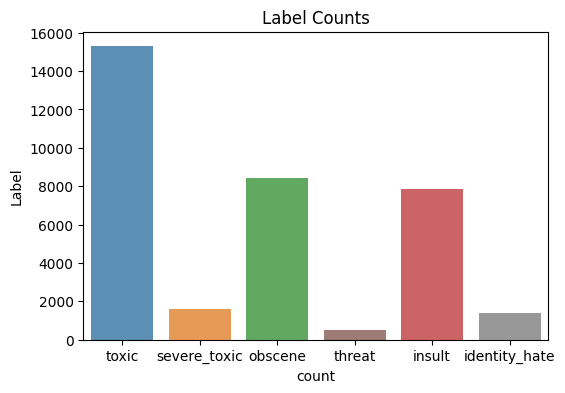

In [9]:
plt.figure(figsize=(6,4))
ax=sns.barplot(x=x.index,y=x.values, alpha=0.8, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:red', 'tab:grey'])
plt.title('Label Counts')
plt.ylabel('Label')
plt.xlabel('count')
plt.show()

In [10]:
df=df.drop(columns=['severe_toxic','threat','identity_hate'])

In [11]:
df.head()

,id,comment_text,toxic,obscene,insult
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0


In [12]:
x=df.iloc[:,2:].sum()
x

toxic      15294
obscene     8449
insult      7877
dtype: int64

In [13]:
df = df.drop(columns=['id'], axis=1)

In [14]:
stopwords=set(stopwords.words('english'))

def remove_stopwords(text):
    no_stopword_text=[w for w in text.split() if not w in stopwords]
    return " ".join(no_stopword_text)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

stemmer=SnowballStemmer('english')

def stemming(sentence):
    stemmed_sentence = ""
    for word in sentence.split():
        stemmed_word = stemmer.stem(word)
        stemmed_sentence += stemmed_word + " "
        
    stemmed_sentence = stemmed_sentence.strip()
    return stemmed_sentence

In [15]:
df['comment_text'] = df['comment_text'].apply(lambda x: remove_stopwords(x))
df['comment_text'] = df['comment_text'].apply(lambda x: clean_text(x))
df['comment_text'] = df['comment_text'].apply(lambda x: stemming(x))
df.head()

,comment_text,toxic,obscene,insult
0,explan whi edit made usernam hardcor metallica...,0,0,0
1,d aww he match background colour i am seem stu...,0,0,0
2,hey man i am realli tri edit war it guy consta...,0,0,0
3,more i can not make real suggest improv i wond...,0,0,0
4,you sir hero ani chanc rememb page that on,0,0,0


In [16]:
X = df['comment_text']
y = df.drop(columns=['comment_text'], axis=1)

In [17]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [18]:
def run_pipeline(pipeline,X_train,X_test,y_train,y_test):
    pipeline.fit(X_train,y_train)
    predictions=pipeline.predict(X_test)
    pred_probs=pipeline.predict(X_test)
    print('roc-auc:',roc_auc_score(y_test,pred_probs))
    print('accuracy:',accuracy_score(y_test,predictions))
    print('classification_report:')
    print(classification_report(y_test,predictions,target_names=y_train.columns))

In [19]:
NB_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('nb_model', OneVsRestClassifier(MultinomialNB(), n_jobs=-1))
])

LR_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('nb_model', OneVsRestClassifier(LogisticRegression(), n_jobs=-1))
])

In [20]:
run_pipeline(NB_pipeline, X_train, X_test, y_train, y_test)

roc-auc: 0.559110831420491
accuracy: 0.9022716590944697
classification_report:
              precision    recall  f1-score   support

       toxic       0.99      0.19      0.32      3056
     obscene       0.98      0.11      0.20      1715
      insult       0.97      0.05      0.10      1614

   micro avg       0.99      0.13      0.24      6385
   macro avg       0.98      0.12      0.21      6385
weighted avg       0.98      0.13      0.23      6385
 samples avg       0.02      0.01      0.01      6385



In [21]:
run_pipeline(LR_pipeline, X_train, X_test, y_train, y_test)

roc-auc: 0.7918571743707833
accuracy: 0.9281842393858687
classification_report:
              precision    recall  f1-score   support

       toxic       0.90      0.62      0.74      3056
     obscene       0.92      0.64      0.75      1715
      insult       0.81      0.50      0.62      1614

   micro avg       0.88      0.60      0.71      6385
   macro avg       0.88      0.59      0.70      6385
weighted avg       0.88      0.60      0.71      6385
 samples avg       0.06      0.05      0.05      6385



In [22]:
labels = y_train.columns.values
labels

array(['toxic', 'obscene', 'insult'], dtype=object)

In [23]:
X_test.sample(1).values[0]

'look like dion phaneuf like catch that problem deni homo lifestyl choic make bigot gay right straight alberta conserv celin biggest hero deserv littl respect 68 149 139 239'

In [24]:
sentence = 'hello dick wikipedia fuckwhit ban'
stemmed_sentence = stemming(sentence)
results = LR_pipeline.predict([stemmed_sentence])[0]
for label, result in zip(labels, results):
    print("%14s %5s" % (label, result))

         toxic     1
       obscene     1
        insult     0


In [25]:
sentence = 'hello how are you doing'
stemmed_sentence = stemming(sentence)
results = LR_pipeline.predict([stemmed_sentence])[0]
for label, result in zip(labels, results):
    print("%14s %5s" % (label, result))

         toxic     0
       obscene     0
        insult     0


In [26]:
df.head()

,comment_text,toxic,obscene,insult
0,explan whi edit made usernam hardcor metallica...,0,0,0
1,d aww he match background colour i am seem stu...,0,0,0
2,hey man i am realli tri edit war it guy consta...,0,0,0
3,more i can not make real suggest improv i wond...,0,0,0
4,you sir hero ani chanc rememb page that on,0,0,0


In [27]:
import pickle
with open('toxic_comment_pipeline.pkl', 'wb') as f:
    pickle.dump(LR_pipeline, f)
with open('toxic_comment_pipeline.pkl','rb')as f:
    loaded_model = pickle.load(f)
results = loaded_model.predict(["You idiot trash person"])[0]

In [28]:
import joblib

# Save your final pipeline
joblib.dump(LR_pipeline, 'comment_model.pkl')


['comment_model.pkl']

In [29]:
sentence = 'You are a fucking stupid'
stemmed_sentence = stemming(sentence)
results = LR_pipeline.predict([stemmed_sentence])[0]
for label, result in zip(labels, results):
    print("%14s %5s" % (label, result))

         toxic     1
       obscene     1
        insult     1
